In [9]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime
from keras.models import Model,Sequential
from keras.layers import  LSTM
from keras.layers.core import Activation, Dropout, Dense
from sklearn.model_selection import train_test_split
from sklearn.linear_model import (LinearRegression,Lasso,Ridge,ElasticNet,HuberRegressor,Lars,LassoLars,
                                  PassiveAggressiveRegressor,RANSACRegressor,SGDRegressor)
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.metrics import  mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima                        
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
import itertools

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [10]:
df = pd.read_csv('Equites_Historical_NonAdjusted_Prices.csv', usecols=['Industry Group', 'Symbol', 
                                                                       'Company Name', 'Date', 'Open', 'High',
                                                                       'Low', 'Close', 'Change', '% Change', 
                                                                       'Volume Traded','Value Traded (SAR)', 
                                                                       'No. of Trades'])

In [11]:
df.Date = pd.to_datetime(df.Date, dayfirst=True)

In [12]:
df.sort_values('Date',inplace=True)

In [13]:
df.head(4)

,Industry Group,Symbol,Company Name,Date,Open,High,Low,Close,Change,% Change,Volume Traded,Value Traded (SAR),No. of Trades
138707,Materials,2260,Sahara Petrochemical Co.,2009-01-03,12.15,12.90,12.10,12.85,0.80,6.63,2617351,32610608.60,989
237007,Retailing,4050,Saudi Automotive Services Co.,2009-01-03,11.75,12.15,11.75,12.05,0.50,4.32,2767819,33195157.05,1206
73500,Materials,2020,Saudi Arabian Fertilizer Co.,2009-01-03,92.00,98.50,92.00,98.50,8.75,9.74,871456,84833829.25,999
407889,Insurance,8180,Al Sagr Cooperative Insurance Co.,2009-01-03,12.15,13.25,12.15,13.25,1.15,9.50,2091187,26429787.35,1209


In [14]:
df['Company Name'].groupby(df['Industry Group']).value_counts()

Industry Group  Company Name                           
Banks           Al Rajhi Bank                              2722
                Alinma Bank                                2722
                Arab National Bank                         2722
                Bank Albilad                               2722
                Bank Aljazira                              2722
                                                           ... 
Transportation  Saudi Public Transport Co.                 2722
                United International Transportation Co.    2722
                Saudi Ground Services Co.                  1102
Utilities       National Gas and Industrialization Co.     2722
                Saudi Electricity Co.                      2722
Name: Company Name, Length: 205, dtype: int64

In [15]:
AbdullatifـIndustrial= df[df['Company Name']== 'Al Abdullatif Industrial Investment Co.']

In [17]:
AbdullatifـIndustrial_for_model = AbdullatifـIndustrial[['Date','Open', 'High', 'Low',
       'Close', 'Change', '% Change']]

In [18]:
AbdullatifـIndustrial_for_model.head(4)

,Date,Open,High,Low,Close,Change,% Change
158984,2009-01-03,44.7,46.1,44.7,46.1,1.5,3.36
158983,2009-01-04,46.0,46.8,45.8,46.6,0.5,1.08
158981,2009-01-05,46.5,47.9,46.4,46.8,0.2,0.42
158982,2009-01-06,47.0,48.2,46.8,47.0,0.2,0.42


In [19]:
AbdullatifـIndustrial_for_model.reset_index(inplace=True)

In [20]:

#Create a data point (i.e. a date) which splits the training and testing set
split_date = list(AbdullatifـIndustrial_for_model["Date"][-(227):])[0]

In [21]:
split_date

Timestamp('2019-01-01 00:00:00')

In [24]:
AbdullatifـIndustrial_for_arima = AbdullatifـIndustrial_for_model[['Date', 'Open', 'High', 'Low', 'Close', 'Change', '% Change']]

In [25]:
AbdullatifـIndustrial_for_arima.set_index('Date',inplace=True)

In [26]:
training_set, test_set = AbdullatifـIndustrial_for_model[AbdullatifـIndustrial_for_model['Date'] < split_date], AbdullatifـIndustrial_for_model[AbdullatifـIndustrial_for_model['Date'] >= split_date]


In [27]:
training_set.shape

(2495, 8)

In [28]:
test_set.shape

(227, 8)

In [29]:
test_set.set_index('Date',inplace=True)

In [30]:
training_set.set_index('Date',inplace=True)

In [31]:
training_set = training_set.drop(['index'], 1)
test_set = test_set.drop(['index'], 1)

In [32]:
training = training_set.values

In [33]:
testing = test_set.values

## LSTM

## Window length

In [34]:
window_len = 5

LSTM_training_inputs = []
for i in range(len(training)-window_len):
    temp_set = training[i:(i+window_len)].copy()
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = training_set['Close'][window_len:].values
LSTM_training_inputs = np.array(LSTM_training_inputs)


#Create windows for testing
LSTM_test_inputs = []
for i in range(len(testing)-window_len):
    temp_set1 = testing[i:(i+window_len)].copy()
    LSTM_test_inputs.append(temp_set1)
LSTM_test_outputs = test_set['Close'][window_len:].values
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [35]:
LSTM_test_inputs.shape

(222, 5, 6)

In [36]:
LSTM_training_inputs.shape

(2490, 5, 6)

In [37]:
# If you want to reste the model 
# nn_model.reset_states()
# nn_model.reset_metrics()

In [38]:
def build_model(inputs, output_size, neurons, activ_func="relu",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [39]:

nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 400)

nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=120, batch_size=160, verbose=1,validation_split= 0.2)

Train on 1992 samples, validate on 498 samples
Epoch 1/120
1992/1992 [==============================] - 1s 696us/step - loss: 33.2695 - val_loss: 13.0865
Epoch 2/120
1992/1992 [==============================] - 1s 349us/step - loss: 33.2695 - val_loss: 13.0865
Epoch 3/120
1992/1992 [==============================] - 1s 330us/step - loss: 33.2695 - val_loss: 13.0865
Epoch 4/120
1992/1992 [==============================] - 1s 319us/step - loss: 33.2695 - val_loss: 13.0865
Epoch 5/120
1992/1992 [==============================] - 1s 365us/step - loss: 33.2695 - val_loss: 13.0865
Epoch 6/120
1992/1992 [==============================] - 1s 384us/step - loss: 33.2695 - val_loss: 13.0865
Epoch 7/120
1992/1992 [==============================] - 1s 373us/step - loss: 33.2695 - val_loss: 13.0865
Epoch 8/120
1992/1992 [==============================] - 1s 370us/step - loss: 33.2695 - val_loss: 13.0865
Epoch 9/120
1992/1992 [==============================] - 1s 357us/step - loss: 33.2695 - val_loss

1992/1992 [==============================] - 1s 485us/step - loss: 33.2695 - val_loss: 13.0865
Epoch 77/120
1992/1992 [==============================] - 1s 497us/step - loss: 33.2695 - val_loss: 13.0865
Epoch 78/120
1992/1992 [==============================] - 1s 492us/step - loss: 33.2695 - val_loss: 13.0865
Epoch 79/120
1992/1992 [==============================] - 1s 480us/step - loss: 33.2695 - val_loss: 13.0865
Epoch 80/120
1992/1992 [==============================] - 1s 492us/step - loss: 33.2695 - val_loss: 13.0865
Epoch 81/120
1992/1992 [==============================] - 1s 489us/step - loss: 33.2695 - val_loss: 13.0865
Epoch 82/120
1992/1992 [==============================] - 1s 470us/step - loss: 33.2695 - val_loss: 13.0865
Epoch 83/120
1992/1992 [==============================] - 1s 473us/step - loss: 33.2695 - val_loss: 13.0865
Epoch 84/120
1992/1992 [==============================] - 1s 559us/step - loss: 33.2695 - val_loss: 13.0865
Epoch 85/120
1992/1992 [=================

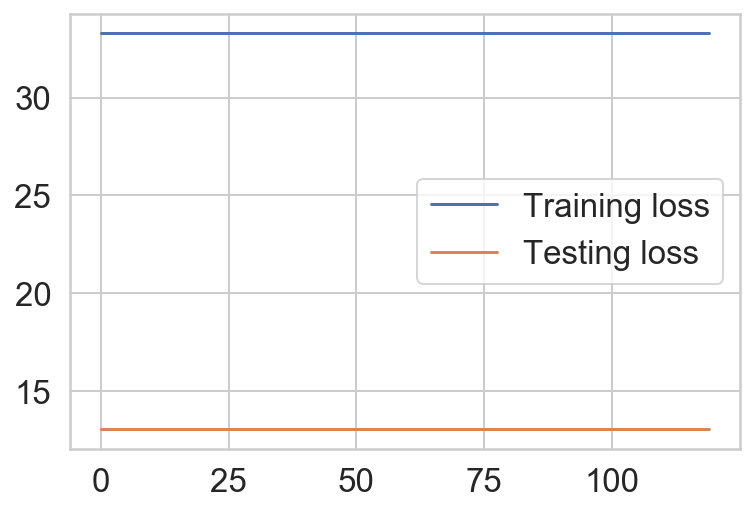

In [40]:
train_loss = nn_history.history['loss']
test_loss = nn_history.history['val_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.legend()

In [41]:
#Reshape from 3D array to 2D array to fit the other models 
X_train = LSTM_training_inputs.reshape((2490,30))
X_test = LSTM_test_inputs.reshape((222,30))

## ARIMA

In [42]:
y = AbdullatifـIndustrial_for_arima['Close'].resample('MS').mean()

In [ ]:
#building the model
from pyramid.arima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)

forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(train, label='Train')
plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()


#calculate rmse
from math import sqrt
from sklearn.metrics import mean_squared_error

rms = sqrt(mean_squared_error(valid,forecast))
print(rms)


In [ ]:
# loading packages
library(forecast)
library(Metrics)

# reading data
data = read.csv("international-airline-passengers.csv")

# splitting data into train and valid sets
train = data[1:100,]
valid = data[101:nrow(data),]

# training model
model = auto.arima(train)

# model summary
summary(model)

# forecasting
forecast = predict(model,44)

# evaluation
rmse(valid$International.airline.passengers, forecast$pred)

In [53]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [51]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
        except:
            continue
        results = mod.fit()
        print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1256.3776197667144
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1014.6095202733493
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:863.910497301239
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:756.3898580171909
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:846.8978870331193
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:829.2302030738657
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:768.9568329864944
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:757.7621144086628
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1079.9383550951532
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:862.9249121577058
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:720.8929624282611
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:631.4330393888777
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:708.7612587067437
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:696.2871503591905
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:654.1289435100696
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:633.4329699529649
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:544.9680918093918
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:492.4254386018477
ARIMA(0,

In [52]:
#ARIMA(0, 1, 2)x(0, 2, 2, 12)12 - AIC:390.88788508639425

mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0,1,2),
                                seasonal_order=(0,2,2,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3434      0.107      3.205      0.001       0.133       0.553
ma.L2         -0.0700      0.093     -0.749      0.454      -0.253       0.113
ma.S.L12      -1.9218   6954.991     -0.000      1.000   -1.36e+04    1.36e+04
ma.S.L24       1.0000   7238.320      0.000      1.000   -1.42e+04    1.42e+04
sigma2         3.9036   2.83e+04      0.000      1.000   -5.54e+04    5.54e+04


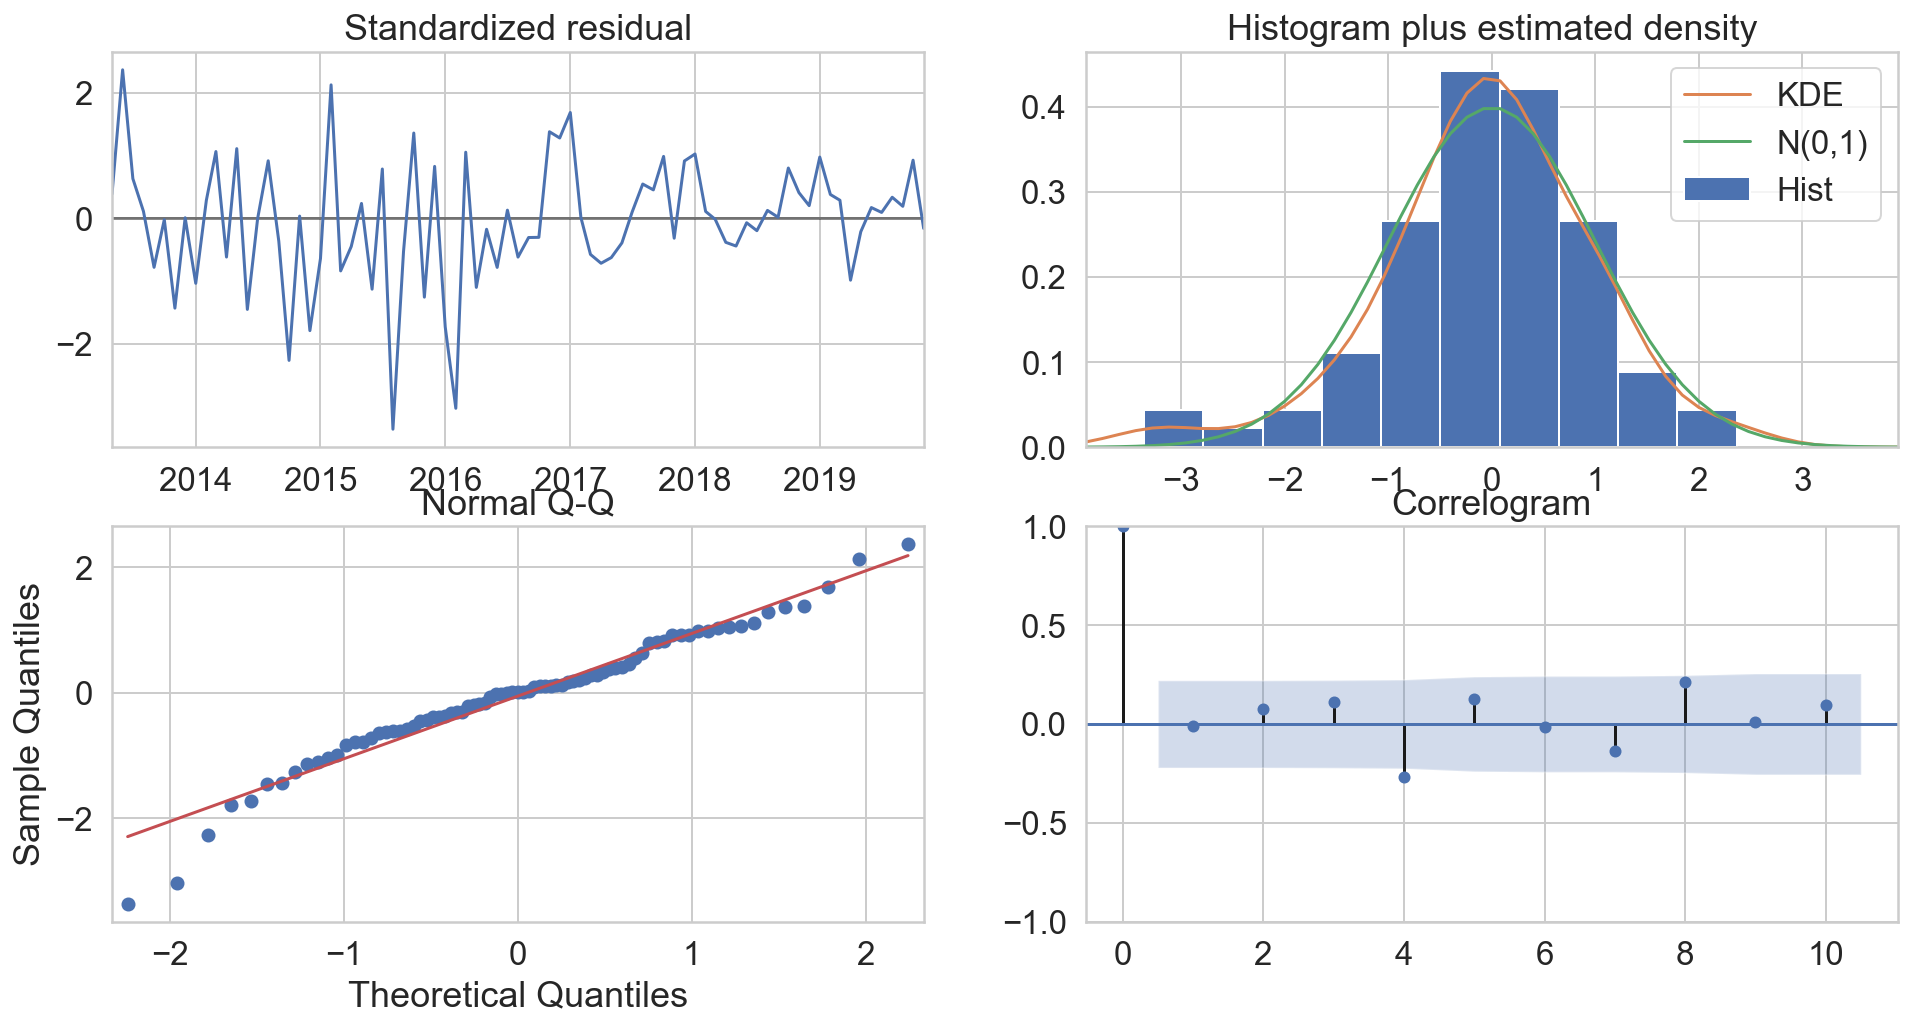

In [46]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Validating forecasts

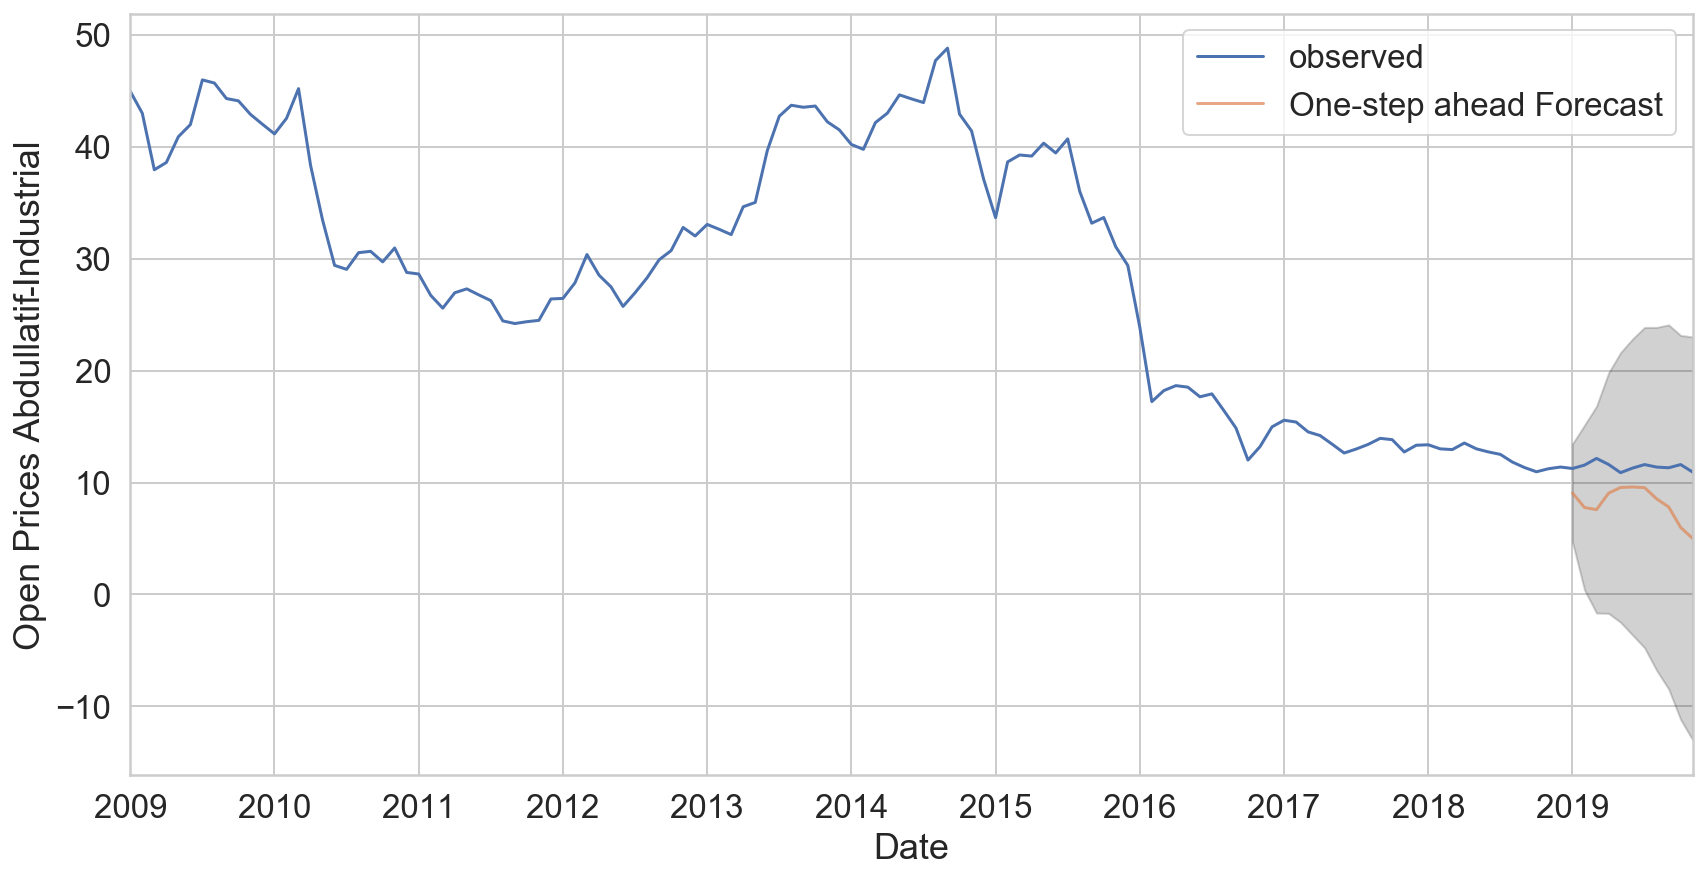

In [47]:
#Here i choose the start of 2019
pred = results.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=True)
pred_ci = pred.conf_int()
ax = y['2009':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Open Prices AbdullatifـIndustrial')
plt.legend()
plt.show()

In [48]:
y_forecasted = pred.predicted_mean
y_truth = y['2019-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 12.95


In [49]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 3.6


## Producing and visualizing forecasts

In [ ]:
pred_uc = results.get_forecast(steps=36)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
plt.legend()
plt.show()

## Model 

In [ ]:
gboost  = GradientBoostingRegressor()
rt      = RandomForestRegressor()
lr      = LinearRegression()
lasso   = Lasso()
ridge   = Ridge()
en      = ElasticNet()
huber   = HuberRegressor()
lars    = Lars()

pa      = PassiveAggressiveRegressor(max_iter=1000, tol=1e-3)
ranscac = RANSACRegressor()

mod = [lr, lasso, ridge, en, huber, lars, pa, ranscac, gboost, rt,# llars, sgd
      ]

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    model.predict(X_train)
    model.predict(X_test)


In [ ]:
for i in mod:
     evaluate_model(i,X_train, LSTM_training_outputs, X_test, LSTM_test_outputs)

In [ ]:
LSTM_pred = nn_model.predict(LSTM_test_inputs).T[0]

In [ ]:
Lr_train_pred = lr.predict(X_train)
Lr_test_pred = lr.predict(X_test)
Lasso_train_pred = lasso.predict(X_train)
Lasso_test_pred = lasso.predict(X_test)
Ridge_train_pred = ridge.predict(X_train)
Ridge_test_pred = ridge.predict(X_test)
ElasticNet_train_pred = en.predict(X_train)
ElasticNet_test_pred = en.predict(X_test)
HuberRegressor_train_pred = huber.predict(X_train)
HuberRegressor_test_pred = huber.predict(X_test)
Lars_train_pred = lars.predict(X_train)
Lars_test_pred = lars.predict(X_test)

PassiveAggressiveRegressor_train_pred = pa.predict(X_train)
PassiveAggressiveRegressor_test_pred = pa.predict(X_test)
RANSACRegressor_train_pred = ranscac.predict(X_train)
RANSACRegressor_test_pred = ranscac.predict(X_test)

GradientBoostingRegressor_train_pred = gboost.predict(X_train)
GradientBoostingRegressor_test_pred = gboost.predict(X_test)
RandomForestRegressor_train_pred  = rt.predict(X_train)
RandomForestRegressor_test_pred  = rt.predict(X_test)

In [ ]:
fig = plt.subplots( figsize=(18,9))
plt.plot(LSTM_training_outputs, label = "actual")
plt.plot(Lr_train_pred, label = "lr")
plt.plot(nn_model.predict(LSTM_training_inputs), label = "LSTM")
plt.plot(Lasso_train_pred, label = "Lasso")
plt.plot(Ridge_train_pred, label = "Ridge")
plt.plot(ElasticNet_train_pred, label = "ElasticNet")
plt.plot(HuberRegressor_train_pred, label = "HuberRegressor")
plt.plot(Lars_train_pred, label = "Lars")
# 
plt.plot(PassiveAggressiveRegressor_train_pred, label = "PassiveAggressiveRegressor")
plt.plot(RandomForestRegressor_train_pred, label = "RandomForestRegressor")
plt.plot(GradientBoostingRegressor_train_pred, label = "GradientBoostingRegressor")
# plt.plot(RANSACRegressor_tradin_pred, label = "RANSACRegressor")

plt.title('Models Predictions on Training  Vs. Actual for 2009 - 2018')
plt.legend()
plt.show()

In [ ]:
fig = plt.subplots( figsize=(20,10))
plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_test_inputs), label = "LSTM")
plt.plot(Lr_test_pred, label = "lr")
plt.plot(Ridge_test_pred, label = "Ridge")
plt.plot(ElasticNet_test_pred, label = "ElasticNet")
plt.plot(HuberRegressor_test_pred, label = "HuberRegressor")
plt.plot(Lars_test_pred, label = "Lars")

plt.plot(PassiveAggressiveRegressor_test_pred, label = "PassiveAggressiveRegressor")
plt.plot(RANSACRegressor_test_pred, label = "RANSACRegressor")

plt.plot(Lasso_test_pred, label = "Lasso")
plt.plot(RandomForestRegressor_test_pred, label = "RandomForestRegressor")
plt.plot(GradientBoostingRegressor_test_pred, label = "GradientBoostingRegressor")
plt.title('Models predictionon test Vs. Actual for 2019')
plt.legend(loc=1)
plt.show()

In [ ]:
predictions_test = pd.DataFrame({'Actual' : LSTM_test_outputs,
                                'Lr' : Lr_test_pred,
                                'Lasso' :Lasso_test_pred  ,
                                'Ridge':Ridge_test_pred ,
                                'ElasticNet' :ElasticNet_test_pred ,
                                'PassiveAggressiveRegressor' :PassiveAggressiveRegressor_test_pred  ,
                                'HuberRegressor': HuberRegressor_test_pred,
                                'Lars' : Lars_test_pred,
                                'RANSACRegressor' : RANSACRegressor_test_pred ,
                                'LSTM':LSTM_pred,
                                'GradientBoostingRegressor':GradientBoostingRegressor_test_pred,
                                'RandomForestRegressor':RandomForestRegressor_test_pred
                                }, 
                                columns=['Actual','Lr','Lasso', 'Ridge','ElasticNet','PassiveAggressiveRegressor',
                                        'HuberRegressor','Lars','RANSACRegressor','LSTM',  'RandomForestRegressor',
                                       'GradientBoostingRegressor' ])

In [ ]:
predictions_test.head()

## Validating our model

In [ ]:
df_new = pd.read_csv('NEWW-Equites_Historical_NonAdjusted_Prices.csv', usecols=['Industry Group', 'Symbol', 
                                                                       'Company Name', 'Date', 'Open', 'High',
                                                                       'Low', 'Close', 'Change', '% Change', 
                                                                       'Volume Traded','Value Traded (SAR)', 
                                                                       'No. of Trades'])

In [ ]:
df_new.Date = pd.to_datetime(df.Date, dayfirst=True)

In [ ]:
df_new.sort_values('Date',inplace=True)

In [ ]:
df_new.head(4)

In [ ]:
AbdullatifـIndustrial_2_weeks = df_new[df_new['Company Name']== 'Al Abdullatif Industrial Investment Co.']

In [ ]:
AbdullatifـIndustrial_2_weeks

In [ ]:
AbdullatifـIndustrial2w_for_model = AbdullatifـIndustrial_2_weeks[['Date','Open', 'High', 'Low',
       'Close', 'Change', '% Change']]

In [ ]:
AbdullatifـIndustrial2w_for_model

In [ ]:
AbdullatifـIndustrial2w_for_model.reset_index(inplace=True)

In [ ]:
asm = AbdullatifـIndustrial_for_model[-6:]

In [ ]:
asm

In [ ]:
AbdullatifـIndustrial2w_for_model

In [ ]:
abr = asm.merge(AbdullatifـIndustrial2w_for_model, how='outer')

In [ ]:
abr.set_index('Date',inplace=True)

In [ ]:
abr.pop('index')

In [ ]:
abr

In [ ]:
abr2=abr[1:].values

In [ ]:
abr2

In [ ]:
X_valid = []
for i in range(len(abr2)-window_len):
    temp_set = abr2[i:(i+window_len)].copy()
    X_valid.append(temp_set)
y_valid = abr['Close'][window_len:].values
X_valid = np.array(X_valid)

In [ ]:
X_valid

In [ ]:
X_valid_resaped = X_valid.reshape(11,30)

In [ ]:
y_valid

In [ ]:
LSTM_valid_pred = nn_model.predict(X_valid).T[0]
Lr_valid_pred = lr.predict(X_valid_resaped)
Lasso_valid_pred = lasso.predict(X_valid_resaped)
Ridge_valid_pred = ridge.predict(X_valid_resaped)
ElasticNet_valid_pred = en.predict(X_valid_resaped)
HuberRegressor_valid_pred = huber.predict(X_valid_resaped)
Lars_valid_pred = lars.predict(X_valid_resaped)

PassiveAggressiveRegressor_valid_pred = pa.predict(X_valid_resaped)
RANSACRegressor_valid_pred = ranscac.predict(X_valid_resaped)

GradientBoostingRegressor_valid_pred = gboost.predict(X_valid_resaped)
RandomForestRegressor_valid_pred  = rt.predict(X_valid_resaped)

In [ ]:
fig = plt.subplots( figsize=(20,10))
plt.plot(y_valid[:-1], label = "actual")
plt.plot(LSTM_valid_pred, label = "LSTM")
plt.plot(Lr_valid_pred, label = "lr")
plt.plot(Ridge_valid_pred, label = "Ridge")
plt.plot(ElasticNet_valid_pred, label = "ElasticNet")
plt.plot(HuberRegressor_valid_pred, label = "HuberRegressor")
plt.plot(Lars_valid_pred, label = "Lars")
# plt.plot(LassoLars_valid_pred, label = "LassoLars")
plt.plot(PassiveAggressiveRegressor_valid_pred, label = "PassiveAggressiveRegressor")
#plt.plot(RANSACRegressor_valid_pred, label = "RANSACRegressor")
# plt.plot(SGDRegressor_valid_pred, label = "SGDRegressor")
plt.plot(Lasso_valid_pred, label = "Lasso")
plt.plot(RandomForestRegressor_valid_pred, label = "RandomForestRegressor")
plt.plot(GradientBoostingRegressor_valid_pred, label = "GradientBoostingRegressor")
plt.legend(loc=2)
plt.show()

In [ ]:
R2_score_valid_LSTM = r2_score(y_valid[:-1],nn_model.predict(X_valid))

In [ ]:
R2_traininig_score_LSTM = r2_score(LSTM_training_outputs,nn_model.predict(LSTM_training_inputs))

In [ ]:
R2_score_test_LSTM=r2_score(LSTM_test_outputs,nn_model.predict(LSTM_test_inputs))

In [ ]:
R2_score_test_LSTM

In [ ]:
R2_traininig_score_LSTM

In [ ]:
R2_score_valid_LSTM

In [ ]:
models = ['LSTM','LR', 'lasso', 'ridge', 'en', 'huber', 'lars', 'pa', #'ranscac',
          'gboost', 'rt']
Training_R2=[R2_traininig_score_LSTM,lr.score(X_train,LSTM_training_outputs),
            lasso.score(X_train,LSTM_training_outputs),ridge.score(X_train,LSTM_training_outputs), 
            en.score(X_train,LSTM_training_outputs),huber.score(X_train,LSTM_training_outputs),
            lars.score(X_train,LSTM_training_outputs),
            pa.score(X_train,LSTM_training_outputs), #ranscac.score(X_train,LSTM_training_outputs),
             gboost.score(X_train,LSTM_training_outputs), rt.score(X_train,LSTM_training_outputs)]
Test_R2=[R2_score_test_LSTM,lr.score(X_test,LSTM_test_outputs),lasso.score(X_test,LSTM_test_outputs), 
         ridge.score(X_test,LSTM_test_outputs),en.score(X_test,LSTM_test_outputs), 
         huber.score(X_test,LSTM_test_outputs),lars.score(X_test,LSTM_test_outputs), 
         pa.score(X_test,LSTM_test_outputs), 
        # ranscac.score(X_test,LSTM_test_outputs), 
         gboost.score(X_test,LSTM_test_outputs),rt.score(X_test,LSTM_test_outputs)]
valid_R2=[R2_score_valid_LSTM,lr.score(X_valid_resaped, y_valid[:-1]),lasso.score(X_valid_resaped, y_valid[:-1]), 
         ridge.score(X_valid_resaped, y_valid[:-1]),en.score(X_valid_resaped, y_valid[:-1]), 
         huber.score(X_valid_resaped, y_valid[:-1]),lars.score(X_valid_resaped, y_valid[:-1]), 
         pa.score(X_valid_resaped, y_valid[:-1]), 
         #ranscac.score(X_valid_resaped, y_valid[:-1]), 
         gboost.score(X_valid_resaped, y_valid[:-1]),rt.score(X_valid_resaped, y_valid[:-1])]

In [ ]:
R2_scores = pd.DataFrame({'models' : models,
                                'Training_R2' : Training_R2,
                                'Test_R2' :Test_R2  ,
                                'valid_R2':valid_R2 ,
                                }, 
                                columns=[ 'models','Training_R2','Test_R2','valid_R2'])

In [ ]:
R2_scores

In [ ]:
fig = plt.subplots( figsize=(20,10))
plt.plot(R2_scores['Training_R2'] ,label = "Training_R2")
plt.plot(R2_scores['Test_R2'] ,label = "Test_R2")
plt.plot(R2_scores['valid_R2'] ,label = "valid_R2")
xlabel=R2_scores['models']
plt.legend()
plt.show()